In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)   #REFERECE: CHATGPT

C:\Users\dson.AzureAD\AppData\Local\Temp\ipykernel_22296\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print("Reflected classes (tables):", Base.classes.keys())


Reflected classes (tables): ['measurement', 'station']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set
print("Most recent date:", session.query(func.max(Measurement.date)).scalar())  #REFERECE: CHATGPT


('2017-08-23',)

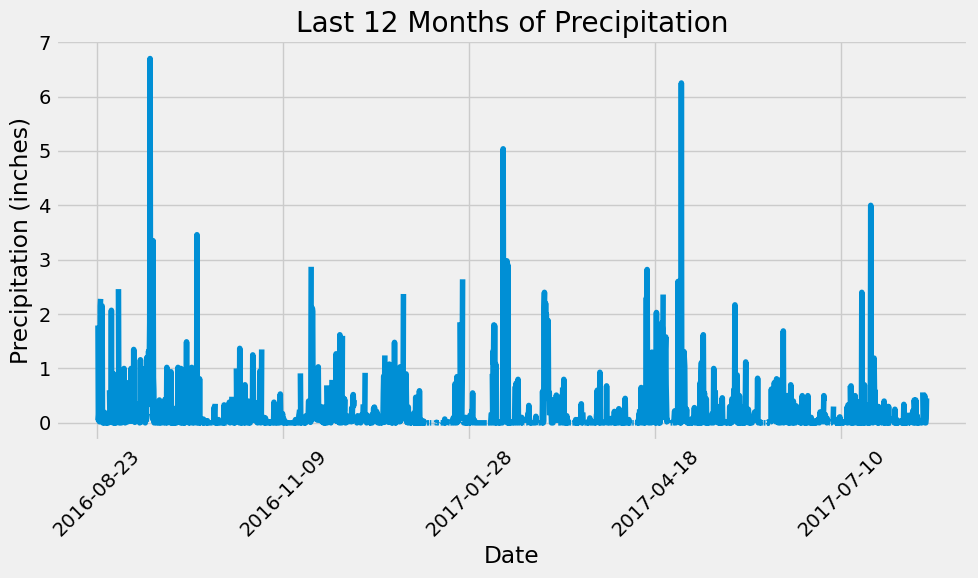

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
one_year_ago = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(one_year_ago) - pd.DateOffset(years=1)


# Perform a query to retrieve the data and precipitation scores     #REFERECE: CHATGPT
precipitation_data = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')) \
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data #REFERECE: CHATGPT
precipitation_df.set_index("date").plot(
    figsize=(10, 6), legend=False, title="Last 12 Months of Precipitation"
)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df["precipitation"].describe()
print(precipitation_summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()
# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. #REFERECE: CHATGPT
most_active_station_id = most_active_stations[0][0] 
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Station {most_active_station_id} - Lowest Temp: {lowest_temp}, Highest Temp: {highest_temp}, Avg Temp: {avg_temp:.2f}")

Station USC00519281 - Lowest Temp: 54.0, Highest Temp: 85.0, Avg Temp: 71.66


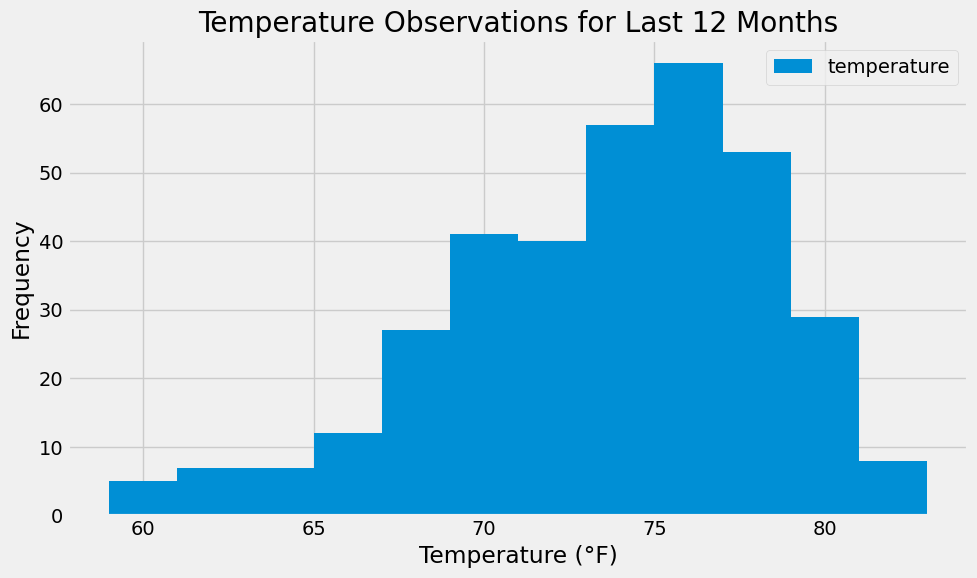

In [16]:
# Using the most active station id
temperature_data = session.query(Measurement.tobs) \
    .filter(Measurement.station == most_active_station_id) \
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')) \
    .all()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_df = pd.DataFrame(temperature_data, columns=["temperature"])
temperature_df.plot(kind="hist", bins=12, figsize=(10, 6), title="Temperature Observations for Last 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()